In [1]:
!pip install keras
!pip install matplotlib
!pip install numpy
!pip install opencv-python
!pip install opencv-contrib-python==3.4.2.17
!pip install pandas
!pip install pillow
!pip install scikit-learn
!pip install scikit-image
!pip install scikit-optimize
!pip install shortuuid
!pip install tensorflow-gpu
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-y8g19t8i
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-y8g19t8i
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-py3-none-any.whl size=84100 sha256=ceb7c0c54a8c6d2501c631ed0ebc6ad65a338a6e3884a2db0ecf323f558558a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-b_uzcjdi/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [1]:
import copy
import csv
import glob
import pathlib
import os
import re
import shutil
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shortuuid
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

from collections import Counter
from datetime import timedelta
from IPython.display import display
from PIL import Image
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator


np.set_printoptions(precision=4)

# Get reproducible results
random_state = 46
np.random.seed(random_state)
tf.random.set_seed(random_state)


def ann_file(data_dir):
    return os.path.join(data_dir, "TrainAnnotations.csv")


TRAIN_DATA_DIR = "data/TrainData-C1"
TRAIN_DATA_ANN_FILE = ann_file(TRAIN_DATA_DIR)

TRAIN_SPLIT_DATA_DIR           = "data-c1/train/split"
TRAIN_SPLIT_ANN_FILE           = ann_file(TRAIN_SPLIT_DATA_DIR)
TRAIN_SPLIT_AUGMENTED_DATA_DIR = "data-c1/train/augmented"
TRAIN_SPLIT_AUGMENTED_ANN_FILE = ann_file(TRAIN_SPLIT_AUGMENTED_DATA_DIR)
TRAIN_SPLIT_PATCHES_DATA_DIR   = "data-c1/train/patches"
TRAIN_SPLIT_PATCHES_ANN_FILE   = ann_file(TRAIN_SPLIT_PATCHES_DATA_DIR)

TRAIN_ALL_AUGMENTED_DATA_DIR   = "data-c1/train-all/augmented"
TRAIN_ALL_AUGMENTED_ANN_FILE   = ann_file(TRAIN_ALL_AUGMENTED_DATA_DIR)
TRAIN_ALL_PATCHES_DATA_DIR     = "data-c1/train-all/patches"
TRAIN_ALL_PATCHES_ANN_FILE     = ann_file(TRAIN_ALL_PATCHES_DATA_DIR)

VAL_SPLIT_DATA_DIR         = "data-c1/val/split"
VAL_SPLIT_ANN_FILE         = ann_file(VAL_SPLIT_DATA_DIR)
VAL_SPLIT_PATCHES_DATA_DIR = "data-c1/val/patches"
VAL_SPLIT_PATCHES_ANN_FILE = ann_file(VAL_SPLIT_PATCHES_DATA_DIR)

TEST_DATA_DIR         = "data/TestData/"
TEST_PATCHES_DATA_DIR = "data/test/patches"

# Keras ImageDataGenerator expects that files are in a subdirectory
TEST_PATCHES_GEN_DATA_DIR = os.path.join(TEST_PATCHES_DATA_DIR, "test")

## GPU configuration
If you have a GPU, enable experimental memory growth.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Split data
Generate random, stratified 80/20 split for training and validation sets

In [186]:
if (os.path.exists(TRAIN_SPLIT_DATA_DIR) or os.path.exists(VAL_SPLIT_DATA_DIR)):
    print("Data directories for splits already exist. Skipping")
else:
    # Generate 80/20 split

    print("Reading {} annotations...".format(TRAIN_DATA_ANN_FILE))
    ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})

    print("Splitting data into training and validation sets...")
    train_df, val_df = train_test_split(ann_df,
                                        train_size=0.80,
                                        random_state=138,
                                        shuffle=True,
                                        stratify=ann_df[['annotation']].to_numpy(dtype=np.int32).flatten())

    os.makedirs(TRAIN_SPLIT_DATA_DIR)
    os.makedirs(VAL_SPLIT_DATA_DIR)
    
    print("Copying files for training split...")
    for _, row in train_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(TRAIN_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating training split annotations...")
    train_df.sort_values('file_name').to_csv(TRAIN_SPLIT_ANN_FILE, index=False)
        
    print("Copying files for validation split...")
    for _, row in val_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(VAL_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating validation split annotations...")
    val_df.sort_values('file_name').to_csv(VAL_SPLIT_ANN_FILE, index=False)
        
    print("Done.")

Data directories for splits already exist. Skipping


## Augment data
Because the training dataset is unbalanced, augment the training data set by generating
new images for the lower numbered samples.

In [3]:
DESIRED_CLASS_SAMPLE_COUNT = 400
RANDOM_STATE = 13

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
PATCH_ROWS = 5
PATCH_COLUMNS = 5


def is_image_file(filename):
    return filename.endswith(IMG_EXTENSIONS)


def augment_data(src_dir, src_ann_file, dest_dir, dest_ann_file, class_sample_count=500):
    os.makedirs(dest_dir)

    ann_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'}) 
    new_samples = {}
    
    for i in range(5):
        class_df = ann_df.query("annotation == '{}'".format(i))
        num_class_samples = class_df.shape[0]
        num_to_create = class_sample_count - num_class_samples
            
        print("Creating {} images for class {}".format(num_to_create, i))
        samples = class_df.sample(n=num_to_create, replace=True, random_state=RANDOM_STATE)
    
        for idx, row in samples.iterrows():
            new_filename = row['file_name'].split('.')[0] + "_" + shortuuid.uuid() + ".png"
    
            # Apply transformations to each randomly selected sample
            img = Image.open(src_dir + "/" + row['file_name'])
            image_transforms = transforms.Compose([
                #transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
                #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                #transforms.RandomResizedCrop((480, 640), scale=(1.0, 1.2)),
                
                transforms.RandomRotation((90,90), expand=True),
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip()
            ])
            transformed_img = image_transforms(img)
            transformed_img.save(os.path.join(dest_dir, new_filename))
    
            new_samples[new_filename] = row['annotation']
    
    # Add to new dataframe
    balanced_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'})
    balanced_df = balanced_df.append(pd.DataFrame.from_records([(k, v) for k, v in new_samples.items()],
                                                 columns=['file_name', 'annotation']))
    
    # Write new annotations
    balanced_df.sort_values('file_name').to_csv(dest_ann_file, index=False)
    
    # Copy images from training data split
    for file in glob.glob(src_dir + "/*"):
        if is_image_file(file):
            shutil.copy(file, os.path.join(dest_dir, os.path.basename(file)))


def generate_image_patches(img, rows, cols):
    """
    Generates a list of in-memory image overlapping patches
    
    Args:
        rows - number of rows of patchs to cover the height of the image
        cols - number of colums of patches to cover the width of the image
    """
    patches = []
    sizeX = img.shape[1]
    sizeY = img.shape[0]
    
    patch_sizeX = 224
    patch_sizeY = 224
    patch_relative_centerX = 112
    patch_relative_centerY = 112

    for i in range(0,rows):
        for j in range(0, cols):
            center = (patch_relative_centerX + (sizeX - patch_sizeX)/(rows - 1)*i, 
                      patch_relative_centerY + (sizeY - patch_sizeY)/(cols - 1)*j)
            patches.append(cv2.getRectSubPix(img, (patch_sizeX, patch_sizeY), center))
            
    return patches


def generate_patch_files(in_dir, out_dir, rows, cols):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    images = [f for f in os.listdir(in_dir) if os.path.isfile(os.path.join(in_dir, f)) and is_image_file(f)]   
    for im in images:
        img = cv2.imread(os.path.join(in_dir, im))
        patches = generate_image_patches(img, rows, cols)
        
        for i in range(0,rows):
            for j in range(0, cols):
                patch = patches[i*rows + j]
                patch_name = im.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                cv2.imwrite(out_dir + '/' + patch_name, patch)


def generate_patch_annotations_df(df, rows, cols):
    patches_ann = {}
    
    for ind in df.index: 
        file_name = df['file_name'][ind]
        annotation = df['annotation'][ind]
        
        for i in range(0, rows):
            for j in range(0, cols):
                patch_name = file_name.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                patches_ann[patch_name] = annotation
    
    return pd.DataFrame.from_records([(k, v) for k, v in patches_ann.items()], 
                                     columns=['file_name', 'annotation'])


### Run data augmentation

Perform the data augmentation on the training data set split to balance the class samples.

In [188]:
if os.path.exists(TRAIN_SPLIT_AUGMENTED_DATA_DIR):
    print("Augmented SPLIT training data already exists. Skipping.")
else:
    print("Balancing class samples for SPLIT training data...")
    augment_data(TRAIN_SPLIT_DATA_DIR,
                 TRAIN_SPLIT_ANN_FILE,
                 TRAIN_SPLIT_AUGMENTED_DATA_DIR,
                 TRAIN_SPLIT_AUGMENTED_ANN_FILE,
                 class_sample_count=400)    
    print("Done.")

if os.path.exists(TRAIN_ALL_AUGMENTED_DATA_DIR):
    print("Augmented ALL training data already exists. Skipping.")
else:
    print("Balancing class samples for ALL training data...")
    augment_data(TRAIN_DATA_DIR,
                 TRAIN_DATA_ANN_FILE,
                 TRAIN_ALL_AUGMENTED_DATA_DIR,
                 TRAIN_ALL_AUGMENTED_ANN_FILE,
                 class_sample_count=500)
    print("Done.")

Augmented SPLIT training data already exists. Skipping.
Augmented ALL training data already exists. Skipping.


## Generate Patches

In [217]:
# SPLIT train patches
if os.path.exists(TRAIN_SPLIT_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_SPLIT_PATCHES_DATA_DIR))
else:
    print("Generating SPLIT training data patches...")
    generate_patch_files(TRAIN_SPLIT_AUGMENTED_DATA_DIR, TRAIN_SPLIT_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating SPLIT training patch data annotations...")
    image_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, index=False)
    
# SPLIT val patches
if os.path.exists(VAL_SPLIT_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(VAL_SPLIT_PATCHES_DATA_DIR))
else:
    print("Generating SPLIT validation data patches...")
    generate_patch_files(VAL_SPLIT_DATA_DIR, VAL_SPLIT_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating SPLIT validation patch data annotations...")
    image_df = pd.read_csv(VAL_SPLIT_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(VAL_SPLIT_PATCHES_ANN_FILE, index=False)

# test patches
if os.path.exists(TEST_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TEST_PATCHES_DATA_DIR))
else:
    print("Generating test data patches...")
    generate_patch_files(TEST_DATA_DIR, TEST_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)
    
# ALL train patches
if os.path.exists(TRAIN_ALL_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_ALL_PATCHES_DATA_DIR))
else:
    print("Generating ALL train data patches...")
    generate_patch_files(TRAIN_ALL_AUGMENTED_DATA_DIR, TRAIN_ALL_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating ALL training patch data annotations...")
    image_df = pd.read_csv(TRAIN_ALL_AUGMENTED_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(TRAIN_ALL_PATCHES_ANN_FILE, index=False)

print("Done.")

data-c1/train/patches exists. Skipping.
data-c1/val/patches exists. Skipping.
data/test/patches exists. Skipping.
Generating ALL train data patches...
Generating ALL training patch data annotations...
Done.


In [4]:
class SoybeanDataGroup():
    def __init__(self, class_weights, 
                 train_generator,
                 train_prediction_generator,
                 val_generator=None,
                 val_prediction_generator=None,
                 test_generator=None,
                 train_patch_ann_df=None,
                 val_patch_ann_df=None,
                 train_whole_image_ann_df=None,
                 val_whole_image_ann_df=None):
        self.class_weights = class_weights
        self.train_generator = train_generator
        self.train_prediction_generator = train_prediction_generator
        self.val_generator = val_generator
        self.val_prediction_generator = val_prediction_generator
        self.test_generator = test_generator
        self.train_patch_ann_df = train_patch_ann_df
        self.val_patch_ann_df = val_patch_ann_df
        self.train_whole_image_ann_df = train_whole_image_ann_df
        self.val_whole_image_ann_df = val_whole_image_ann_df

In [5]:
def train_val_split_group(class_weights=None):
    
    train_whole_image_ann_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    val_whole_image_ann_df   = pd.read_csv(VAL_SPLIT_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    print("Reading annotations...")
    train_ann_df = pd.read_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    val_ann_df   = pd.read_csv(VAL_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(train_ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)
        
        
    data_gen_args = dict(
        samplewise_center=True,
        samplewise_std_normalization=True
        #preprocessing_function=tf.keras.applications.vgg16.preprocess_input,

        #rotation_range=10,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #horizontal_flip=True
    )
    train_datagen = ImageDataGenerator(**data_gen_args)
    val_datagen = ImageDataGenerator(**data_gen_args)


    print("Defining train data generator...")
    train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_ann_df,
            directory=TRAIN_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            y_col="annotation",
            batch_size=BATCH_SIZE,
            class_mode='sparse',
            target_size=(224,224)
    )
    
    train_prediction_generator = train_datagen.flow_from_dataframe(
            dataframe=train_ann_df,
            directory=TRAIN_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            batch_size=BATCH_SIZE,
            class_mode=None,
            shuffle=False,
            target_size=(224,224)
    )
    
    print("Defining validation data generator...")
    val_generator = val_datagen.flow_from_dataframe(
            dataframe=val_ann_df,
            directory=VAL_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            y_col="annotation",
            batch_size=BATCH_SIZE,
            class_mode='sparse',
            target_size=(224,224)
    )
    
    
    val_prediction_generator = val_datagen.flow_from_dataframe(
            dataframe=val_ann_df,
            directory=VAL_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            batch_size=BATCH_SIZE,
            class_mode=None,
            shuffle=False,
            target_size=(224,224)
    )
        
    test_datagen = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True
        #preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    )

    test_generator = test_datagen.flow_from_directory(
        directory=TEST_PATCHES_DATA_DIR,
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False,
        target_size=(224,224)
    )
    
    return SoybeanDataGroup(class_weights, 
                            train_generator,
                            train_prediction_generator,
                            val_generator, 
                            val_prediction_generator,
                            test_generator,
                            train_ann_df,
                            val_ann_df,
                            train_whole_image_ann_df, 
                            val_whole_image_ann_df)


In [6]:
def all_train_data_group(class_weights=None):
    
    train_whole_image_ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})    
    
    print("Reading annotations...")
    ann_df = pd.read_csv(TRAIN_ALL_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)
        
    train_datagen = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True
        # preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    )

    print("Defining train data generator...")
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=ann_df,
        directory=TRAIN_ALL_PATCHES_DATA_DIR,
        x_col="file_name",
        y_col="annotation",
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        target_size=(224,224)
    )
    
    train_prediction_generator = train_datagen.flow_from_dataframe(
        dataframe=ann_df,
        directory=TRAIN_ALL_PATCHES_DATA_DIR,
        x_col="file_name",
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False,
        target_size=(224,224)
    )
   
        
    test_datagen = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True
        # preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    )

    test_generator = test_datagen.flow_from_directory(
        directory=TEST_PATCHES_DATA_DIR,
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False,
        target_size=(224,224)
    )  
    
    
    return SoybeanDataGroup(class_weights, 
                            train_generator,
                            train_prediction_generator,
                            None, 
                            None,
                            test_generator,
                            ann_df,
                            None,
                            train_whole_image_ann_df)

## Model

This model is based on the VGG16 network with custom classifier layers 
with the feature layers initialized with weights based on the ImageNet data. 

The number of neurons and dropout rates in the classifier layers are parameterized.

In [7]:
def get_model(n1, n2, dropout):
    vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
    vgg_model.trainable = False

    model = tf.keras.models.Sequential([
        vgg_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(n1, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(n2, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(5)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

## Training loop
For training and validation, this trains a model across a configured number of epochs and outputs the training and validation loss and accuracy for each epoch.

In [8]:
BATCH_SIZE = 32

def compute_class_weights(df, y_col):
    """
    Returns a dictionary mapping class labels to 'balanced' weights based on the
    frequency of the weights across the labels in the specified dataframe
    """
    y = df[[y_col]].to_numpy().flatten()
    weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
    return {label: weight for label, weight in enumerate(weights)}
    

def train(run_id, model, group, num_epochs):     
    model.summary()

    print('Fitting model...')
    
    print('group.train_patch_ann_df.shape[0]=', group.train_patch_ann_df.shape[0])
    print('int(group.train_patch_ann_df.shape[0] / BATCH_SIZE)', int(group.train_patch_ann_df.shape[0] / BATCH_SIZE))

    monitor = 'val_loss' if group.val_generator is not None else 'loss'
    es = tf.keras.callbacks.EarlyStopping(monitor=monitor, mode='min', verbose=1, patience=10, restore_best_weights=True)
    
    
    validation_steps = None if group.val_generator is None else int(group.val_patch_ann_df.shape[0] / BATCH_SIZE)
    
    history = model.fit(group.train_generator, 
                        steps_per_epoch=int(group.train_patch_ann_df.shape[0] / BATCH_SIZE), 
                        epochs=num_epochs,  
                        class_weight=group.class_weights,
                        validation_data=group.val_generator,
                        validation_steps=validation_steps,
                        verbose=1,
                        callbacks=[es])

    
    return model, history


def get_all_labels(ann_df):
    return ann_df['annotation'].to_numpy(dtype=int)


def get_all_whole_image_filenames(whole_image_ann_df):
    return whole_image_ann_df['file_name'].to_numpy()
    

def get_all_whole_image_labels(ann_df):
    return get_all_labels(ann_df)


def get_all_whole_image_predictions(patch_preds):
    patch_pred_groups = np.split(patch_preds, int(len(patch_preds)/(PATCH_ROWS * PATCH_COLUMNS)))
    image_preds = np.array(list(map(lambda x: stats.mode(x).mode[0], patch_pred_groups)))
    return image_preds


def plot_metrics(run_id, output_dir, model, history, group):
    
    print()
    print('Metrics')
    print('-' * 10)
    
    # Loss vs Epochs plot
    plt.plot(history.history['loss'], label='Training loss')
    
    if group.val_generator is not None:
        plt.plot(history.history['val_loss'], label = 'Validation loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()
    
    # Accuracy vs Epochs plot
    plt.plot(history.history['accuracy'], label='Training accuracy')
    
    if group.val_generator is not None:
        plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
        
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()
    
    
    target_names = ['Crop 0', 'Crop 1', 'Crop 2', 'Crop 3', 'Crop 4']

    # Training confusion matrix
    train_patch_labels = get_all_labels(group.train_patch_ann_df)
    train_patch_predictions = predict(model, group.train_prediction_generator)
    
    print("Training Confusion Matrix of Patches")
    print("-" * 30)
    print_confusion_matrix(train_patch_labels, train_patch_predictions)
    
    print(classification_report(y_true=train_patch_labels, y_pred=train_patch_predictions, target_names=target_names))
    
    # Generate prediction label results file
    write_patch_predictions(run_id, 'train', output_dir, group.train_patch_ann_df, train_patch_predictions)
    
    
    print("Training Confusion Matrix of Whole Images")
    print("-" * 30)
    train_whole_image_filenames = get_all_whole_image_filenames(group.train_whole_image_ann_df)
    train_whole_image_labels = get_all_whole_image_labels(group.train_whole_image_ann_df)
    train_whole_image_predictions = get_all_whole_image_predictions(train_patch_predictions)
    print_confusion_matrix(train_whole_image_labels, train_whole_image_predictions)
    
    print(classification_report(y_true=train_whole_image_labels, y_pred=train_whole_image_predictions, target_names=target_names))
    
    write_whole_image_predictions(run_id, 'train', output_dir, 
                                  train_whole_image_filenames, 
                                  train_whole_image_labels, 
                                  train_whole_image_predictions)
    
    # Validation confusion matrix
    if group.val_generator is not None:
        val_patch_labels = get_all_labels(group.val_patch_ann_df)
        val_patch_predictions = predict(model, group.val_prediction_generator)
        
        print("Validation Confusion Matrix of Patches")
        print("-" * 30)
        print_confusion_matrix(val_patch_labels, val_patch_predictions)
      
        print(classification_report(y_true=val_patch_labels, y_pred=val_patch_predictions, target_names=target_names))
        
        print("Validation Confusion Matrix of Whole Images")
        print("-" * 30)
        val_whole_image_filenames = get_all_whole_image_filenames(group.val_whole_image_ann_df)
        val_whole_image_labels = get_all_whole_image_labels(group.val_whole_image_ann_df)
        val_whole_image_predictions = get_all_whole_image_predictions(val_patch_predictions)
        print_confusion_matrix(val_whole_image_labels, val_whole_image_predictions)
        
        print(classification_report(y_true=val_whole_image_labels, y_pred=val_whole_image_predictions, target_names=target_names))
        
        # Generate prediction label results file
        write_patch_predictions(run_id, 'val', output_dir, group.val_patch_ann_df, val_patch_predictions)
        
        write_whole_image_predictions(run_id, 'val', output_dir, 
                                  val_whole_image_filenames, 
                                  val_whole_image_labels, 
                                  val_whole_image_predictions)
    


def train_and_test(run_id, model, group, num_epochs, output_dir):    
    model_trained, history = train(run_id, model, group, num_epochs)
    
    # Save weights
    model_trained.save_weights(os.path.join(output_dir, "{}_weights.h5".format(run_id)))
    
    # Plot history metrics
    plot_metrics(run_id, output_dir, model_trained, history, group)
    
    # Classify test data
    return predict(model_trained, group.test_generator)


def predict(model, data_generator):
    y_hat_logits = model.predict(data_generator)
    y_hat = tf.map_fn(lambda x: tf.argmax(x), y_hat_logits, dtype=tf.int64).numpy()
    print('prediction => ', np.bincount(y_hat))
    return y_hat



def predict_whole_images(patch_predictions, rows, columns, csvfile):
    y_hat_test = patch_predictions
    y_hat_patch_groups = np.split(y_hat_test, int(len(y_hat_test)/(rows * columns)))
    y_hat_whole_images = list(map(lambda x: stats.mode(x).mode[0], y_hat_patch_groups))

    print("Distribution")
    print('-' * 8)
    for k, v in sorted(Counter(y_hat_whole_images).items()): 
        print(str(k) + ': '+ str(v))    

    one_hots = [np.zeros((5,1)) for pred in y_hat_whole_images]
    for i in range(len(one_hots)):
        pred = y_hat_whole_images[i]  # the index of the one-hot encoding
        one_hots[i][pred] = 1
    with open(csvfile, 'w') as predictions_file:
        writer = csv.writer(predictions_file)
        for pred in one_hots:
            pred = np.array(pred, dtype=int)
            writer.writerow(pred.T.tolist()[0])
    print('Finished generating predictions to', csvfile)


def print_confusion_matrix(y, y_hat):
    labels = [0, 1, 2, 3, 4]
    matrix = confusion_matrix(y, y_hat)
    df = pd.DataFrame(matrix, index=labels, columns=labels)
    display(df)


def write_patch_predictions(run_id, phase, output_dir, patch_ann_df, patch_predictions):
    df = pd.DataFrame(columns=['file_name', 'annotation', 'prediction'])
    i = 0
    for idx, row in patch_ann_df.iterrows():
        file_name, label = row
        df = df.append({'file_name': file_name, 
                        'annotation': label, 
                        'prediction': patch_predictions[i]}, ignore_index=True)
        i += 1

    df.to_csv(os.path.join(output_dir, "{}_{}_patch_predictions.csv".format(run_id, phase)), index=False)
    

def write_whole_image_predictions(run_id, phase, output_dir, filenames, labels, predictions):
    df = pd.DataFrame(columns=['file_name', 'annotation', 'prediction'])
    for i in range(len(filenames)):
        df = df.append({'file_name': filenames[i], 
                        'annotation': labels[i], 
                        'prediction': predictions[i]}, ignore_index=True)
        
    df.to_csv(os.path.join(output_dir, "{}_{}_whole_image_predictions.csv".format(run_id, phase)), index=False)
        

## Hyperparameter Optimization
The following hyperparameters can be tuned:
1. `n1` - Number of neurons in the first classifier dense layer
2. `n2` - Number of neurons in the second classifier dense layer
3. `d` - Dropout rate after classifier dense layers
4. class weights - `[1,1,1,1,1]` (default) or `[1,1,5,5,1]`
5. batch normalization - `no` or `yes`



In [9]:
def run_trial(name, model, group=None, class_weights=None, num_epochs=80):
    run_id = shortuuid.uuid()
    
    if group is None:
        group = train_val_split_group(class_weights)
    
    # output directory
    output_dir = os.path.join("output_tf", run_id)
    os.makedirs(output_dir)
    print("Output generated to:", output_dir)
    
    
    y_hat_test = train_and_test(run_id, model, group, num_epochs, output_dir)
    predictions_file = os.path.join(output_dir, "{}_predict_c2_{}_test.csv".format(run_id, name))
    print('predictions file:', predictions_file)
    predict_whole_images(y_hat_test, PATCH_ROWS, PATCH_COLUMNS, predictions_file)
    return y_hat_test

#### H1: 1024-128-5

* DNN Structure: 1024-128-5
* Dropout: 0.5
* Class weights: balanced


Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/eHa9jcADsjw7W2GUr6qvQF
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_11  (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1024)        

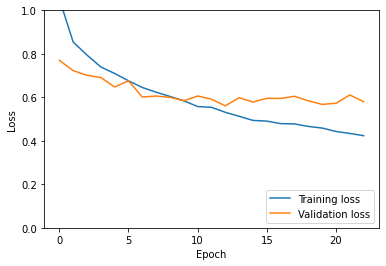

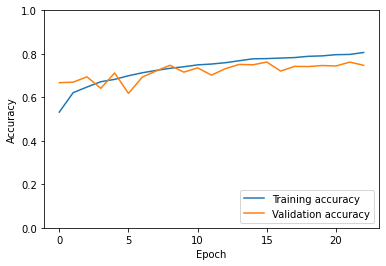

prediction =>  [7772 5345 3125 2312 1946]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,7348,2084,299,19,0
1,353,3060,266,21,0
2,66,179,2223,124,8
3,5,22,337,2101,160
4,0,0,0,47,1778


              precision    recall  f1-score   support

      Crop 0       0.95      0.75      0.84      9750
      Crop 1       0.57      0.83      0.68      3700
      Crop 2       0.71      0.85      0.78      2600
      Crop 3       0.91      0.80      0.85      2625
      Crop 4       0.91      0.97      0.94      1825

    accuracy                           0.81     20500
   macro avg       0.81      0.84      0.82     20500
weighted avg       0.84      0.81      0.81     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,318,68,4,0,0
1,10,133,5,0,0
2,1,4,97,2,0
3,0,0,11,92,2
4,0,0,0,0,73


              precision    recall  f1-score   support

      Crop 0       0.97      0.82      0.88       390
      Crop 1       0.65      0.90      0.75       148
      Crop 2       0.83      0.93      0.88       104
      Crop 3       0.98      0.88      0.92       105
      Crop 4       0.97      1.00      0.99        73

    accuracy                           0.87       820
   macro avg       0.88      0.90      0.89       820
weighted avg       0.89      0.87      0.87       820

prediction =>  [1808 1411  846  585  475]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1691,588,165,6,0
1,99,721,100,5,0
2,16,79,457,98,0
3,2,23,123,454,48
4,0,0,1,22,427


              precision    recall  f1-score   support

      Crop 0       0.94      0.69      0.79      2450
      Crop 1       0.51      0.78      0.62       925
      Crop 2       0.54      0.70      0.61       650
      Crop 3       0.78      0.70      0.74       650
      Crop 4       0.90      0.95      0.92       450

    accuracy                           0.73      5125
   macro avg       0.73      0.76      0.74      5125
weighted avg       0.79      0.73      0.74      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,75,20,3,0,0
1,4,30,3,0,0
2,0,1,24,1,0
3,0,0,4,21,1
4,0,0,0,1,17


              precision    recall  f1-score   support

      Crop 0       0.95      0.77      0.85        98
      Crop 1       0.59      0.81      0.68        37
      Crop 2       0.71      0.92      0.80        26
      Crop 3       0.91      0.81      0.86        26
      Crop 4       0.94      0.94      0.94        18

    accuracy                           0.81       205
   macro avg       0.82      0.85      0.83       205
weighted avg       0.85      0.81      0.82       205

prediction =>  [1797 1198  462  372 1171]
predictions file: output_tf/eHa9jcADsjw7W2GUr6qvQF/eHa9jcADsjw7W2GUr6qvQF_predict_c2_h1_test.csv
Distribution
--------
0: 77
1: 54
2: 11
3: 6
4: 52
Finished generating predictions to output_tf/eHa9jcADsjw7W2GUr6qvQF/eHa9jcADsjw7W2GUr6qvQF_predict_c2_h1_test.csv


array([2, 2, 2, ..., 0, 0, 0])

In [36]:
model = get_model(1024, 128, 0.5)
run_trial("h1", model)

#### H2: 1024-128-5, d=0.25

* DNN Structure: 1024-128-5
* Dropout: 0.25
* Class weights: balanced

Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/XKoXFRLHoXdPx46xFJwU6L
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_12  (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1024)        

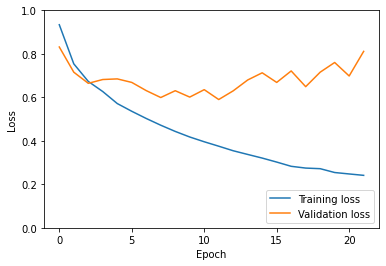

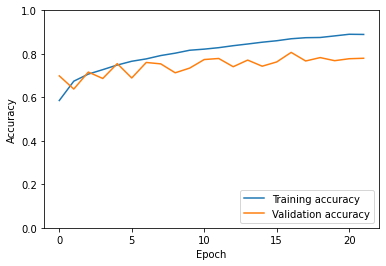

prediction =>  [9306 3378 3550 2467 1799]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,8672,693,362,23,0
1,607,2656,403,34,0
2,22,22,2519,37,0
3,5,7,266,2310,37
4,0,0,0,63,1762


              precision    recall  f1-score   support

      Crop 0       0.93      0.89      0.91      9750
      Crop 1       0.79      0.72      0.75      3700
      Crop 2       0.71      0.97      0.82      2600
      Crop 3       0.94      0.88      0.91      2625
      Crop 4       0.98      0.97      0.97      1825

    accuracy                           0.87     20500
   macro avg       0.87      0.88      0.87     20500
weighted avg       0.88      0.87      0.87     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,368,19,3,0,0
1,17,124,7,0,0
2,0,0,104,0,0
3,0,0,7,98,0
4,0,0,0,1,72


              precision    recall  f1-score   support

      Crop 0       0.96      0.94      0.95       390
      Crop 1       0.87      0.84      0.85       148
      Crop 2       0.86      1.00      0.92       104
      Crop 3       0.99      0.93      0.96       105
      Crop 4       1.00      0.99      0.99        73

    accuracy                           0.93       820
   macro avg       0.93      0.94      0.94       820
weighted avg       0.94      0.93      0.93       820

prediction =>  [2210  869  954  652  440]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1991,243,202,14,0
1,190,588,139,8,0
2,24,30,497,99,0
3,5,8,114,499,24
4,0,0,2,32,416


              precision    recall  f1-score   support

      Crop 0       0.90      0.81      0.85      2450
      Crop 1       0.68      0.64      0.66       925
      Crop 2       0.52      0.76      0.62       650
      Crop 3       0.77      0.77      0.77       650
      Crop 4       0.95      0.92      0.93       450

    accuracy                           0.78      5125
   macro avg       0.76      0.78      0.77      5125
weighted avg       0.80      0.78      0.78      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,84,9,5,0,0
1,8,26,3,0,0
2,0,1,24,1,0
3,0,0,3,23,0
4,0,0,0,1,17


              precision    recall  f1-score   support

      Crop 0       0.91      0.86      0.88        98
      Crop 1       0.72      0.70      0.71        37
      Crop 2       0.69      0.92      0.79        26
      Crop 3       0.92      0.88      0.90        26
      Crop 4       1.00      0.94      0.97        18

    accuracy                           0.85       205
   macro avg       0.85      0.86      0.85       205
weighted avg       0.86      0.85      0.85       205

prediction =>  [2007  769  694  527 1003]
predictions file: output_tf/XKoXFRLHoXdPx46xFJwU6L/XKoXFRLHoXdPx46xFJwU6L_predict_c2_h2_test.csv
Distribution
--------
0: 88
1: 30
2: 21
3: 14
4: 47
Finished generating predictions to output_tf/XKoXFRLHoXdPx46xFJwU6L/XKoXFRLHoXdPx46xFJwU6L_predict_c2_h2_test.csv


array([0, 2, 2, ..., 0, 0, 0])

In [37]:
model = get_model(1024, 128, 0.25)
run_trial("h2", model)

#### H3: 1024-128-5, d=0.1

* DNN Structure: 1024-128-5
* Dropout: 0.1
* Class weights: balanced

Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/ggZTwhBgNX9XeXtaiduxSH
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_13  (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 1024)        

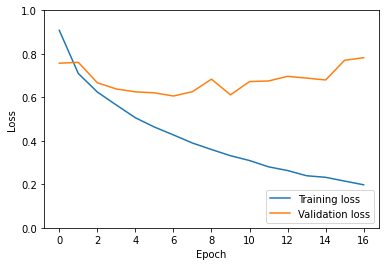

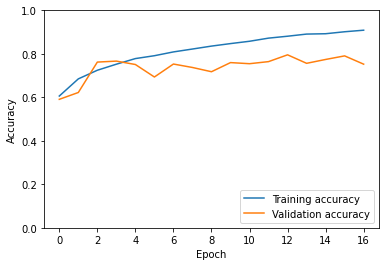

prediction =>  [8517 4394 2976 2540 2073]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,8048,1360,301,41,0
1,405,2937,272,85,1
2,58,86,2184,245,27
3,6,11,219,2150,239
4,0,0,0,19,1806


              precision    recall  f1-score   support

      Crop 0       0.94      0.83      0.88      9750
      Crop 1       0.67      0.79      0.73      3700
      Crop 2       0.73      0.84      0.78      2600
      Crop 3       0.85      0.82      0.83      2625
      Crop 4       0.87      0.99      0.93      1825

    accuracy                           0.84     20500
   macro avg       0.81      0.85      0.83     20500
weighted avg       0.85      0.84      0.84     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,348,40,2,0,0
1,9,134,4,1,0
2,1,1,98,3,1
3,0,0,6,91,8
4,0,0,0,0,73


              precision    recall  f1-score   support

      Crop 0       0.97      0.89      0.93       390
      Crop 1       0.77      0.91      0.83       148
      Crop 2       0.89      0.94      0.92       104
      Crop 3       0.96      0.87      0.91       105
      Crop 4       0.89      1.00      0.94        73

    accuracy                           0.91       820
   macro avg       0.90      0.92      0.91       820
weighted avg       0.92      0.91      0.91       820

prediction =>  [2044 1138  737  705  501]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1877,400,150,23,0
1,144,658,110,13,0
2,21,68,392,156,13
3,2,12,85,498,53
4,0,0,0,15,435


              precision    recall  f1-score   support

      Crop 0       0.92      0.77      0.84      2450
      Crop 1       0.58      0.71      0.64       925
      Crop 2       0.53      0.60      0.57       650
      Crop 3       0.71      0.77      0.74       650
      Crop 4       0.87      0.97      0.91       450

    accuracy                           0.75      5125
   macro avg       0.72      0.76      0.74      5125
weighted avg       0.78      0.75      0.76      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,84,11,3,0,0
1,5,29,3,0,0
2,1,2,17,6,0
3,0,0,3,21,2
4,0,0,0,0,18


              precision    recall  f1-score   support

      Crop 0       0.93      0.86      0.89        98
      Crop 1       0.69      0.78      0.73        37
      Crop 2       0.65      0.65      0.65        26
      Crop 3       0.78      0.81      0.79        26
      Crop 4       0.90      1.00      0.95        18

    accuracy                           0.82       205
   macro avg       0.79      0.82      0.80       205
weighted avg       0.83      0.82      0.83       205

prediction =>  [1718  986  528  399 1369]
predictions file: output_tf/ggZTwhBgNX9XeXtaiduxSH/ggZTwhBgNX9XeXtaiduxSH_predict_c2_h3_test.csv
Distribution
--------
0: 75
1: 42
2: 17
3: 10
4: 56
Finished generating predictions to output_tf/ggZTwhBgNX9XeXtaiduxSH/ggZTwhBgNX9XeXtaiduxSH_predict_c2_h3_test.csv


array([0, 2, 2, ..., 0, 0, 0])

In [38]:
model = get_model(1024, 128, 0.1)
run_trial("h3", model)

#### H4: 2048-256-5

* DNN Structure: 2048-256-5
* Dropout: 0.5
* Class weights: balanced
* Batch normalization: no


Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/2BMjEhGJFaPD5avx53PgEm
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_14  (None, 512)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 2048)        

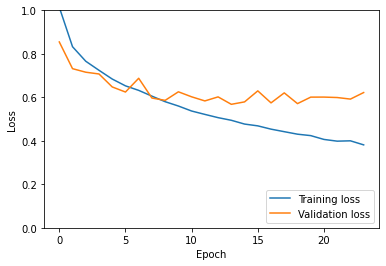

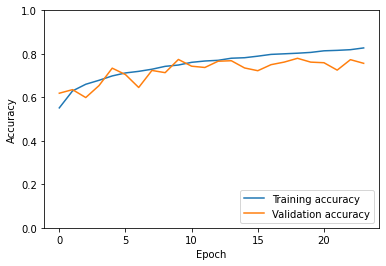

prediction =>  [8787 4513 3003 2143 2054]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,8211,1339,192,8,0
1,482,2987,213,18,0
2,79,160,2260,86,15
3,15,27,338,2011,234
4,0,0,0,20,1805


              precision    recall  f1-score   support

      Crop 0       0.93      0.84      0.89      9750
      Crop 1       0.66      0.81      0.73      3700
      Crop 2       0.75      0.87      0.81      2600
      Crop 3       0.94      0.77      0.84      2625
      Crop 4       0.88      0.99      0.93      1825

    accuracy                           0.84     20500
   macro avg       0.83      0.85      0.84     20500
weighted avg       0.86      0.84      0.85     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,348,40,2,0,0
1,13,132,3,0,0
2,1,3,100,0,0
3,0,0,11,86,8
4,0,0,0,0,73


              precision    recall  f1-score   support

      Crop 0       0.96      0.89      0.93       390
      Crop 1       0.75      0.89      0.82       148
      Crop 2       0.86      0.96      0.91       104
      Crop 3       1.00      0.82      0.90       105
      Crop 4       0.90      1.00      0.95        73

    accuracy                           0.90       820
   macro avg       0.90      0.91      0.90       820
weighted avg       0.91      0.90      0.90       820

prediction =>  [2095 1196  784  554  496]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1920,410,114,6,0
1,143,683,95,4,0
2,27,74,457,89,3
3,5,29,117,441,58
4,0,0,1,14,435


              precision    recall  f1-score   support

      Crop 0       0.92      0.78      0.84      2450
      Crop 1       0.57      0.74      0.64       925
      Crop 2       0.58      0.70      0.64       650
      Crop 3       0.80      0.68      0.73       650
      Crop 4       0.88      0.97      0.92       450

    accuracy                           0.77      5125
   macro avg       0.75      0.77      0.76      5125
weighted avg       0.79      0.77      0.77      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,84,12,2,0,0
1,5,29,3,0,0
2,0,1,23,2,0
3,0,0,3,21,2
4,0,0,0,0,18


              precision    recall  f1-score   support

      Crop 0       0.94      0.86      0.90        98
      Crop 1       0.69      0.78      0.73        37
      Crop 2       0.74      0.88      0.81        26
      Crop 3       0.91      0.81      0.86        26
      Crop 4       0.90      1.00      0.95        18

    accuracy                           0.85       205
   macro avg       0.84      0.87      0.85       205
weighted avg       0.86      0.85      0.86       205

prediction =>  [1962 1110  412  275 1241]
predictions file: output_tf/2BMjEhGJFaPD5avx53PgEm/2BMjEhGJFaPD5avx53PgEm_predict_c2_h4_test.csv
Distribution
--------
0: 85
1: 51
2: 8
3: 1
4: 55
Finished generating predictions to output_tf/2BMjEhGJFaPD5avx53PgEm/2BMjEhGJFaPD5avx53PgEm_predict_c2_h4_test.csv


array([0, 2, 2, ..., 0, 0, 0])

In [39]:
model = get_model(2048, 256, 0.5)
run_trial("h4", model)

#### H5: 512-64-5

* DNN Structure: 512-64-5
* Dropout: 0.5
* Class weights: balanced


Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/YPxzMyVy3W23p3jeqFs888
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_15  (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 512)         

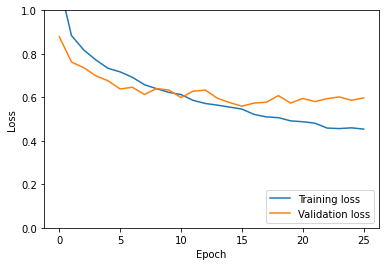

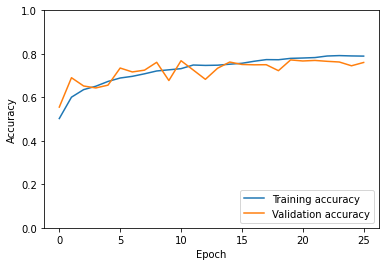

prediction =>  [8366 4887 3014 2350 1883]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,7753,1714,276,7,0
1,516,2935,207,42,0
2,88,216,2165,129,2
3,9,22,366,2104,124
4,0,0,0,68,1757


              precision    recall  f1-score   support

      Crop 0       0.93      0.80      0.86      9750
      Crop 1       0.60      0.79      0.68      3700
      Crop 2       0.72      0.83      0.77      2600
      Crop 3       0.90      0.80      0.85      2625
      Crop 4       0.93      0.96      0.95      1825

    accuracy                           0.82     20500
   macro avg       0.81      0.84      0.82     20500
weighted avg       0.84      0.82      0.82     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,332,56,2,0,0
1,15,131,2,0,0
2,2,6,95,1,0
3,0,0,13,91,1
4,0,0,0,1,72


              precision    recall  f1-score   support

      Crop 0       0.95      0.85      0.90       390
      Crop 1       0.68      0.89      0.77       148
      Crop 2       0.85      0.91      0.88       104
      Crop 3       0.98      0.87      0.92       105
      Crop 4       0.99      0.99      0.99        73

    accuracy                           0.88       820
   macro avg       0.89      0.90      0.89       820
weighted avg       0.90      0.88      0.88       820

prediction =>  [1977 1304  777  607  460]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1829,482,135,4,0
1,123,703,88,11,0
2,23,92,428,107,0
3,2,27,124,463,34
4,0,0,2,22,426


              precision    recall  f1-score   support

      Crop 0       0.93      0.75      0.83      2450
      Crop 1       0.54      0.76      0.63       925
      Crop 2       0.55      0.66      0.60       650
      Crop 3       0.76      0.71      0.74       650
      Crop 4       0.93      0.95      0.94       450

    accuracy                           0.75      5125
   macro avg       0.74      0.76      0.75      5125
weighted avg       0.79      0.75      0.76      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,78,17,3,0,0
1,5,29,3,0,0
2,0,2,21,3,0
3,0,0,3,23,0
4,0,0,0,0,18


              precision    recall  f1-score   support

      Crop 0       0.94      0.80      0.86        98
      Crop 1       0.60      0.78      0.68        37
      Crop 2       0.70      0.81      0.75        26
      Crop 3       0.88      0.88      0.88        26
      Crop 4       1.00      1.00      1.00        18

    accuracy                           0.82       205
   macro avg       0.83      0.85      0.84       205
weighted avg       0.85      0.82      0.83       205

prediction =>  [1637 1216  439  603 1105]
predictions file: output_tf/YPxzMyVy3W23p3jeqFs888/YPxzMyVy3W23p3jeqFs888_predict_c2_h5_test.csv
Distribution
--------
0: 65
1: 58
2: 12
3: 15
4: 50
Finished generating predictions to output_tf/YPxzMyVy3W23p3jeqFs888/YPxzMyVy3W23p3jeqFs888_predict_c2_h5_test.csv


array([0, 2, 0, ..., 0, 0, 0])

In [40]:
model = get_model(512, 64, 0.5)
run_trial("h5", model)

#### H6: 512-128-5

* DNN Structure: 512-128-5
* Dropout: 0.5
* Class weights: balanced

Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/TJRQZVbzgsfZuGfFfxm7Ny
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_16  (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 512)         

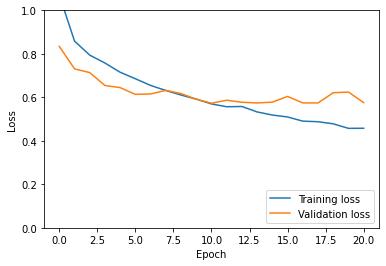

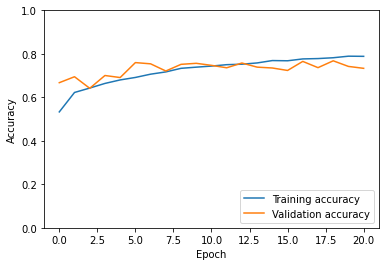

prediction =>  [8340 4755 2803 2697 1905]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,7658,1708,356,28,0
1,596,2804,241,59,0
2,80,203,1973,331,13
3,6,40,233,2188,158
4,0,0,0,91,1734


              precision    recall  f1-score   support

      Crop 0       0.92      0.79      0.85      9750
      Crop 1       0.59      0.76      0.66      3700
      Crop 2       0.70      0.76      0.73      2600
      Crop 3       0.81      0.83      0.82      2625
      Crop 4       0.91      0.95      0.93      1825

    accuracy                           0.80     20500
   macro avg       0.79      0.82      0.80     20500
weighted avg       0.82      0.80      0.80     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,331,56,3,0,0
1,19,124,5,0,0
2,1,7,90,5,1
3,0,0,7,95,3
4,0,0,0,1,72


              precision    recall  f1-score   support

      Crop 0       0.94      0.85      0.89       390
      Crop 1       0.66      0.84      0.74       148
      Crop 2       0.86      0.87      0.86       104
      Crop 3       0.94      0.90      0.92       105
      Crop 4       0.95      0.99      0.97        73

    accuracy                           0.87       820
   macro avg       0.87      0.89      0.88       820
weighted avg       0.88      0.87      0.87       820

prediction =>  [1944 1272  748  701  460]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1806,458,175,11,0
1,116,709,79,21,0
2,19,83,397,150,1
3,3,22,97,493,35
4,0,0,0,26,424


              precision    recall  f1-score   support

      Crop 0       0.93      0.74      0.82      2450
      Crop 1       0.56      0.77      0.65       925
      Crop 2       0.53      0.61      0.57       650
      Crop 3       0.70      0.76      0.73       650
      Crop 4       0.92      0.94      0.93       450

    accuracy                           0.75      5125
   macro avg       0.73      0.76      0.74      5125
weighted avg       0.78      0.75      0.76      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,78,16,4,0,0
1,5,30,2,0,0
2,0,2,16,8,0
3,0,0,3,23,0
4,0,0,0,1,17


              precision    recall  f1-score   support

      Crop 0       0.94      0.80      0.86        98
      Crop 1       0.62      0.81      0.71        37
      Crop 2       0.64      0.62      0.63        26
      Crop 3       0.72      0.88      0.79        26
      Crop 4       1.00      0.94      0.97        18

    accuracy                           0.80       205
   macro avg       0.78      0.81      0.79       205
weighted avg       0.82      0.80      0.80       205

prediction =>  [1626 1461  266  451 1196]
predictions file: output_tf/TJRQZVbzgsfZuGfFfxm7Ny/TJRQZVbzgsfZuGfFfxm7Ny_predict_c2_h6_test.csv
Distribution
--------
0: 65
1: 71
2: 3
3: 9
4: 52
Finished generating predictions to output_tf/TJRQZVbzgsfZuGfFfxm7Ny/TJRQZVbzgsfZuGfFfxm7Ny_predict_c2_h6_test.csv


array([0, 2, 2, ..., 0, 0, 0])

In [41]:
model = get_model(512, 128, 0.5)
run_trial("h6", model)

#### H7: 512-256-5

* DNN Structure: 512-256-5
* Dropout: 0.5
* Class weights: balanced

Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/bjEpweFmRQ3i5ogGBD5qPs
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_17  (None, 512)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 512)         

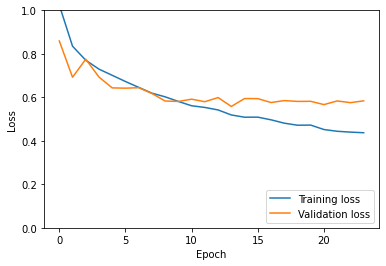

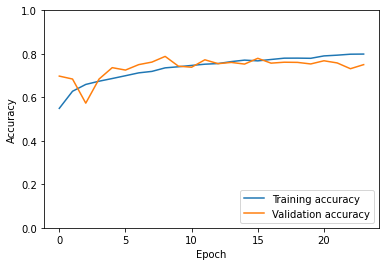

prediction =>  [8801 4246 3021 2579 1853]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,8101,1312,317,20,0
1,617,2772,270,41,0
2,76,140,2179,202,3
3,7,22,255,2238,103
4,0,0,0,78,1747


              precision    recall  f1-score   support

      Crop 0       0.92      0.83      0.87      9750
      Crop 1       0.65      0.75      0.70      3700
      Crop 2       0.72      0.84      0.78      2600
      Crop 3       0.87      0.85      0.86      2625
      Crop 4       0.94      0.96      0.95      1825

    accuracy                           0.83     20500
   macro avg       0.82      0.85      0.83     20500
weighted avg       0.84      0.83      0.83     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,351,36,3,0,0
1,17,128,3,0,0
2,1,2,99,2,0
3,0,0,7,96,2
4,0,0,0,1,72


              precision    recall  f1-score   support

      Crop 0       0.95      0.90      0.92       390
      Crop 1       0.77      0.86      0.82       148
      Crop 2       0.88      0.95      0.92       104
      Crop 3       0.97      0.91      0.94       105
      Crop 4       0.97      0.99      0.98        73

    accuracy                           0.91       820
   macro avg       0.91      0.92      0.92       820
weighted avg       0.91      0.91      0.91       820

prediction =>  [2032 1169  781  688  455]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1867,400,176,7,0
1,138,680,98,9,0
2,25,65,424,136,0
3,2,24,82,507,35
4,0,0,1,29,420


              precision    recall  f1-score   support

      Crop 0       0.92      0.76      0.83      2450
      Crop 1       0.58      0.74      0.65       925
      Crop 2       0.54      0.65      0.59       650
      Crop 3       0.74      0.78      0.76       650
      Crop 4       0.92      0.93      0.93       450

    accuracy                           0.76      5125
   macro avg       0.74      0.77      0.75      5125
weighted avg       0.79      0.76      0.77      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,82,13,3,0,0
1,5,30,2,0,0
2,0,2,19,5,0
3,0,0,3,23,0
4,0,0,0,1,17


              precision    recall  f1-score   support

      Crop 0       0.94      0.84      0.89        98
      Crop 1       0.67      0.81      0.73        37
      Crop 2       0.70      0.73      0.72        26
      Crop 3       0.79      0.88      0.84        26
      Crop 4       1.00      0.94      0.97        18

    accuracy                           0.83       205
   macro avg       0.82      0.84      0.83       205
weighted avg       0.85      0.83      0.84       205

prediction =>  [1970  949  456  466 1159]
predictions file: output_tf/bjEpweFmRQ3i5ogGBD5qPs/bjEpweFmRQ3i5ogGBD5qPs_predict_c2_h7_test.csv
Distribution
--------
0: 87
1: 40
2: 9
3: 10
4: 54
Finished generating predictions to output_tf/bjEpweFmRQ3i5ogGBD5qPs/bjEpweFmRQ3i5ogGBD5qPs_predict_c2_h7_test.csv


array([0, 2, 2, ..., 0, 0, 0])

In [42]:
model = get_model(512, 256, 0.5)
run_trial("h7", model)

#### H8: 1024-256-5

* DNN Structure: 1024-256-5
* Dropout: 0.5
* Class weights: balanced

Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/Wv7PmycroSskhJ8i7SBBwy
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_18  (None, 512)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 1024)        

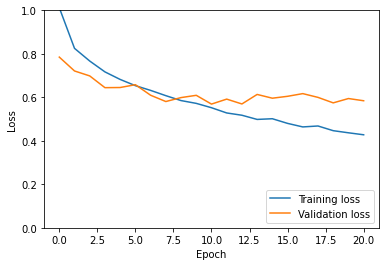

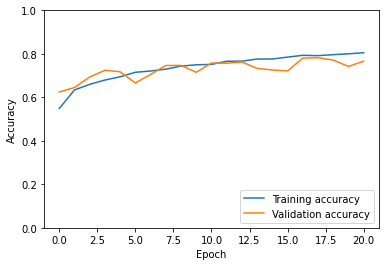

prediction =>  [8242 4982 3321 2209 1746]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,7694,1791,257,8,0
1,441,2978,266,15,0
2,92,183,2251,74,0
3,15,29,542,1976,63
4,0,1,5,136,1683


              precision    recall  f1-score   support

      Crop 0       0.93      0.79      0.86      9750
      Crop 1       0.60      0.80      0.69      3700
      Crop 2       0.68      0.87      0.76      2600
      Crop 3       0.89      0.75      0.82      2625
      Crop 4       0.96      0.92      0.94      1825

    accuracy                           0.81     20500
   macro avg       0.81      0.83      0.81     20500
weighted avg       0.84      0.81      0.82     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,327,60,3,0,0
1,10,134,4,0,0
2,1,3,100,0,0
3,0,0,17,87,1
4,0,0,0,3,70


              precision    recall  f1-score   support

      Crop 0       0.97      0.84      0.90       390
      Crop 1       0.68      0.91      0.78       148
      Crop 2       0.81      0.96      0.88       104
      Crop 3       0.97      0.83      0.89       105
      Crop 4       0.99      0.96      0.97        73

    accuracy                           0.88       820
   macro avg       0.88      0.90      0.88       820
weighted avg       0.90      0.88      0.88       820

prediction =>  [1991 1259  926  518  431]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1838,479,131,2,0
1,123,699,103,0,0
2,24,61,514,51,0
3,6,20,174,426,24
4,0,0,4,39,407


              precision    recall  f1-score   support

      Crop 0       0.92      0.75      0.83      2450
      Crop 1       0.56      0.76      0.64       925
      Crop 2       0.56      0.79      0.65       650
      Crop 3       0.82      0.66      0.73       650
      Crop 4       0.94      0.90      0.92       450

    accuracy                           0.76      5125
   macro avg       0.76      0.77      0.75      5125
weighted avg       0.80      0.76      0.77      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,79,16,3,0,0
1,4,30,3,0,0
2,0,1,25,0,0
3,0,0,4,22,0
4,0,0,0,1,17


              precision    recall  f1-score   support

      Crop 0       0.95      0.81      0.87        98
      Crop 1       0.64      0.81      0.71        37
      Crop 2       0.71      0.96      0.82        26
      Crop 3       0.96      0.85      0.90        26
      Crop 4       1.00      0.94      0.97        18

    accuracy                           0.84       205
   macro avg       0.85      0.87      0.86       205
weighted avg       0.87      0.84      0.85       205

prediction =>  [1809 1095  615  563  918]
predictions file: output_tf/Wv7PmycroSskhJ8i7SBBwy/Wv7PmycroSskhJ8i7SBBwy_predict_c2_h8_test.csv
Distribution
--------
0: 74
1: 49
2: 19
3: 17
4: 41
Finished generating predictions to output_tf/Wv7PmycroSskhJ8i7SBBwy/Wv7PmycroSskhJ8i7SBBwy_predict_c2_h8_test.csv


array([0, 2, 2, ..., 0, 0, 0])

In [43]:
model = get_model(1024, 256, 0.5)
run_trial("h8", model)

#### Summary: Best hyperparameters

In [44]:
optimal_n1 = 512
optimal_n2 = 256
optimal_d = 0.5


## Train with all data and optimal hyperparameters

Reading annotations...
Computing class weights...
{0: 0.42008196721311475, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.5648854961832062, 4: 2.2527472527472527}
Defining train data generator...
Found 25625 validated image filenames belonging to 5 classes.
Found 25625 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/fJJB3Q3JMSwPY3gUM2Tqky
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_19  (None, 512)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_38 (Dropout)         (None, 512)            

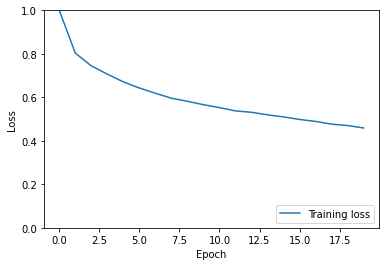

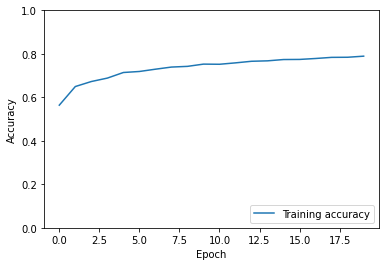

prediction =>  [9654 6727 4129 2846 2269]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,9247,2548,399,6,0
1,348,3965,298,14,0
2,56,168,2932,93,1
3,3,46,500,2658,68
4,0,0,0,75,2200


              precision    recall  f1-score   support

      Crop 0       0.96      0.76      0.85     12200
      Crop 1       0.59      0.86      0.70      4625
      Crop 2       0.71      0.90      0.79      3250
      Crop 3       0.93      0.81      0.87      3275
      Crop 4       0.97      0.97      0.97      2275

    accuracy                           0.82     25625
   macro avg       0.83      0.86      0.84     25625
weighted avg       0.86      0.82      0.83     25625

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,405,78,5,0,0
1,7,172,6,0,0
2,1,3,126,0,0
3,0,0,15,115,1
4,0,0,0,0,91


              precision    recall  f1-score   support

      Crop 0       0.98      0.83      0.90       488
      Crop 1       0.68      0.93      0.79       185
      Crop 2       0.83      0.97      0.89       130
      Crop 3       1.00      0.88      0.93       131
      Crop 4       0.99      1.00      0.99        91

    accuracy                           0.89      1025
   macro avg       0.90      0.92      0.90      1025
weighted avg       0.91      0.89      0.89      1025

prediction =>  [1515 1602  381  539  963]
predictions file: output_tf/fJJB3Q3JMSwPY3gUM2Tqky/fJJB3Q3JMSwPY3gUM2Tqky_predict_c2_a1_test.csv
Distribution
--------
0: 63
1: 73
2: 6
3: 14
4: 44
Finished generating predictions to output_tf/fJJB3Q3JMSwPY3gUM2Tqky/fJJB3Q3JMSwPY3gUM2Tqky_predict_c2_a1_test.csv


array([1, 2, 0, ..., 0, 0, 0])

In [45]:
model = get_model(optimal_n1, optimal_n2, optimal_d)
run_trial("a1", model, group=all_train_data_group(), num_epochs=20)


Reading annotations...
Computing class weights...
{0: 0.42008196721311475, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.5648854961832062, 4: 2.2527472527472527}
Defining train data generator...
Found 25625 validated image filenames belonging to 5 classes.
Found 25625 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/5am2edGo2zpJff5G27aw5w
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_20  (None, 512)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_40 (Dropout)         (None, 1024)           

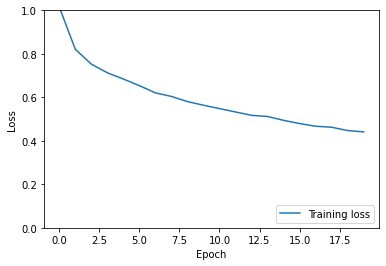

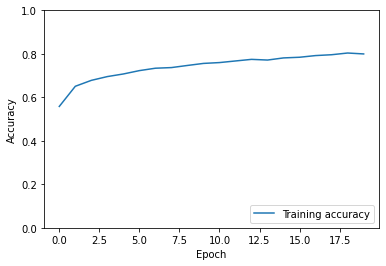

prediction =>  [10892  5241  4160  3083  2249]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,10249,1595,342,14,0
1,568,3566,456,35,0
2,72,71,2994,113,0
3,3,9,367,2845,51
4,0,0,1,76,2198


              precision    recall  f1-score   support

      Crop 0       0.94      0.84      0.89     12200
      Crop 1       0.68      0.77      0.72      4625
      Crop 2       0.72      0.92      0.81      3250
      Crop 3       0.92      0.87      0.89      3275
      Crop 4       0.98      0.97      0.97      2275

    accuracy                           0.85     25625
   macro avg       0.85      0.87      0.86     25625
weighted avg       0.87      0.85      0.86     25625

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,437,47,4,0,0
1,16,157,12,0,0
2,1,1,128,0,0
3,0,0,14,117,0
4,0,0,0,1,90


              precision    recall  f1-score   support

      Crop 0       0.96      0.90      0.93       488
      Crop 1       0.77      0.85      0.81       185
      Crop 2       0.81      0.98      0.89       130
      Crop 3       0.99      0.89      0.94       131
      Crop 4       1.00      0.99      0.99        91

    accuracy                           0.91      1025
   macro avg       0.91      0.92      0.91      1025
weighted avg       0.91      0.91      0.91      1025

prediction =>  [1880  859  680  607  974]
predictions file: output_tf/5am2edGo2zpJff5G27aw5w/5am2edGo2zpJff5G27aw5w_predict_c2_a1_test.csv
Distribution
--------
0: 79
1: 32
2: 26
3: 19
4: 44
Finished generating predictions to output_tf/5am2edGo2zpJff5G27aw5w/5am2edGo2zpJff5G27aw5w_predict_c2_a1_test.csv


array([0, 2, 2, ..., 0, 0, 0])

In [46]:
model = get_model(1024, 128, 0.5)
run_trial("a1", model, group=all_train_data_group(), num_epochs=20)


Reading annotations...
Computing class weights...
{0: 0.42008196721311475, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.5648854961832062, 4: 2.2527472527472527}
Defining train data generator...
Found 25625 validated image filenames belonging to 5 classes.
Found 25625 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/esN5kgmXJLm8VA8vj568c7
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_21  (None, 512)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_42 (Dropout)         (None, 1024)           

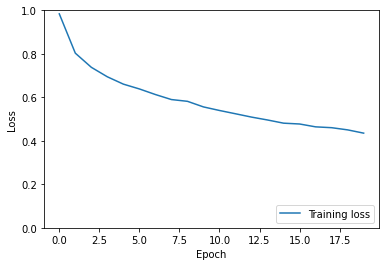

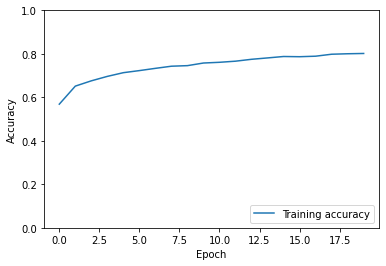

prediction =>  [10678  5855  3618  3122  2352]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,10125,1816,248,11,0
1,470,3872,250,33,0
2,78,133,2837,195,7
3,5,34,283,2842,111
4,0,0,0,41,2234


              precision    recall  f1-score   support

      Crop 0       0.95      0.83      0.89     12200
      Crop 1       0.66      0.84      0.74      4625
      Crop 2       0.78      0.87      0.83      3250
      Crop 3       0.91      0.87      0.89      3275
      Crop 4       0.95      0.98      0.97      2275

    accuracy                           0.86     25625
   macro avg       0.85      0.88      0.86     25625
weighted avg       0.87      0.86      0.86     25625

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,431,56,1,0,0
1,11,169,5,0,0
2,1,1,127,1,0
3,0,0,8,122,1
4,0,0,0,0,91


              precision    recall  f1-score   support

      Crop 0       0.97      0.88      0.93       488
      Crop 1       0.75      0.91      0.82       185
      Crop 2       0.90      0.98      0.94       130
      Crop 3       0.99      0.93      0.96       131
      Crop 4       0.99      1.00      0.99        91

    accuracy                           0.92      1025
   macro avg       0.92      0.94      0.93      1025
weighted avg       0.93      0.92      0.92      1025

prediction =>  [2074 1098  266  490 1072]
predictions file: output_tf/esN5kgmXJLm8VA8vj568c7/esN5kgmXJLm8VA8vj568c7_predict_c2_a3_test.csv
Distribution
--------
0: 94
1: 44
2: 3
3: 11
4: 48
Finished generating predictions to output_tf/esN5kgmXJLm8VA8vj568c7/esN5kgmXJLm8VA8vj568c7_predict_c2_a3_test.csv


array([0, 0, 0, ..., 0, 0, 0])

In [47]:
model = get_model(1024, 256, 0.5)
run_trial("a3", model, group=all_train_data_group(), num_epochs=20)


Reading annotations...
Computing class weights...
{0: 0.42008196721311475, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.5648854961832062, 4: 2.2527472527472527}
Defining train data generator...
Found 25625 validated image filenames belonging to 5 classes.
Found 25625 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/gbWcQJtE4axpqFMXh6ZZRQ
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               

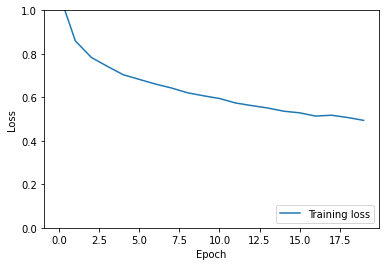

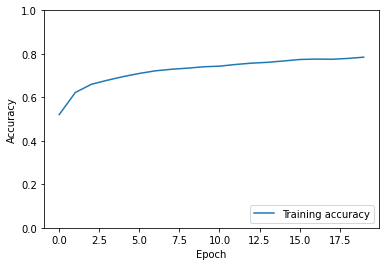

prediction =>  [11054  5144  4380  2593  2454]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,10308,1480,399,13,0
1,680,3536,389,20,0
2,65,103,3030,49,3
3,1,25,560,2489,200
4,0,0,2,22,2251


              precision    recall  f1-score   support

      Crop 0       0.93      0.84      0.89     12200
      Crop 1       0.69      0.76      0.72      4625
      Crop 2       0.69      0.93      0.79      3250
      Crop 3       0.96      0.76      0.85      3275
      Crop 4       0.92      0.99      0.95      2275

    accuracy                           0.84     25625
   macro avg       0.84      0.86      0.84     25625
weighted avg       0.86      0.84      0.85     25625

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,444,41,3,0,0
1,19,156,10,0,0
2,1,1,128,0,0
3,0,0,19,109,3
4,0,0,0,0,91


              precision    recall  f1-score   support

      Crop 0       0.96      0.91      0.93       488
      Crop 1       0.79      0.84      0.81       185
      Crop 2       0.80      0.98      0.88       130
      Crop 3       1.00      0.83      0.91       131
      Crop 4       0.97      1.00      0.98        91

    accuracy                           0.91      1025
   macro avg       0.90      0.91      0.90      1025
weighted avg       0.91      0.91      0.91      1025

prediction =>  [1884 1121  489  338 1168]
predictions file: output_tf/gbWcQJtE4axpqFMXh6ZZRQ/gbWcQJtE4axpqFMXh6ZZRQ_predict_c2_a4_test.csv
Distribution
--------
0: 79
1: 51
2: 12
3: 4
4: 54
Finished generating predictions to output_tf/gbWcQJtE4axpqFMXh6ZZRQ/gbWcQJtE4axpqFMXh6ZZRQ_predict_c2_a4_test.csv


array([0, 2, 2, ..., 0, 0, 0])

In [10]:
model = get_model(512, 64, 0.5)
run_trial("a4", model, group=all_train_data_group(), num_epochs=20)
